## Segmentation multi-organes en IRM abdominale </font></br></div>


L'objectif de ce projet est de développer un **modèle de segmentation multi-organes** (foie, reins et rate) à partir d'images IRM T2 abdominales.



### 1 - Gestion des données

La fonction `read_train_exam(exam_nb)` fournie ci-dessous permets de lire pour un examen d'apprentissage d'indice `exam_nb` :
- l'image acquise en modalité T2
- un masque de segmentation vérité-terrain (1 : foie, 2 : rein droit, 3 : rein gauche, 4 : rate)



In [1]:
!unzip chaos-data.zip

Archive:  chaos-data.zip
   creating: chaos-data/
  inflating: __MACOSX/._chaos-data   
  inflating: chaos-data/01-T2SPIR-src.nii.gz  
  inflating: chaos-data/.DS_Store    
  inflating: __MACOSX/chaos-data/._.DS_Store  
  inflating: chaos-data/19-T2SPIR-mask.nii.gz  
  inflating: chaos-data/Icon         
  inflating: __MACOSX/chaos-data/._Icon  
  inflating: chaos-data/05-T2SPIR-src.nii.gz  
  inflating: chaos-data/19-T2SPIR-src.nii.gz  
  inflating: chaos-data/03-T2SPIR-src.nii.gz  
  inflating: chaos-data/02-T2SPIR-mask.nii.gz  
  inflating: chaos-data/32-T2SPIR-src.nii.gz  
  inflating: chaos-data/02-T2SPIR-src.nii.gz  
  inflating: chaos-data/01-T2SPIR-mask.nii.gz  
  inflating: chaos-data/10-T2SPIR-mask.nii.gz  
  inflating: chaos-data/13-T2SPIR-src.nii.gz  
  inflating: chaos-data/22-T2SPIR-src.nii.gz  
  inflating: chaos-data/13-T2SPIR-mask.nii.gz  
  inflating: chaos-data/03-T2SPIR-mask.nii.gz  
  inflating: chaos-data/10-T2SPIR-src.nii.gz  
  inflating: chaos-data/05-T2SPIR-ma

In [2]:
!unzip "Masques vérité-terrains associées aux données de test-20251203.zip" -d chaos-data/

Archive:  Masques vérité-terrains associées aux données de test-20251203.zip
  inflating: chaos-data/21-T2SPIR-mask.nii.gz  
  inflating: chaos-data/22-T2SPIR-mask.nii.gz  
  inflating: chaos-data/32-T2SPIR-mask.nii.gz  
  inflating: chaos-data/39-T2SPIR-mask.nii.gz  


In [19]:
import nibabel

def read_train_exam(exam_nb):
    image = nibabel.load('/content/chaos-data/%02d-T2SPIR-src.nii.gz' % (exam_nb))
    mask  = nibabel.load('/content/chaos-data/%02d-T2SPIR-mask.nii.gz' % (exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('/content/chaos-data/%02d-T2SPIR-src.nii.gz' % (exam_nb))
    return image

Les examens 1, 2, 3, 5, 8, 10, 13 et 19 serviront d'examens d'apprentissage tandis que les examens 21, 22, 32 et 39 serviront d'examens de test. Les masques associés aux examens d'apprentissage sont fournis. Les masques associés aux examens de test seront fournis à la fin du projet (début de séance 12), pour évaluation.

In [4]:
train_ids = [1,2,3,5,8,10,13,19]
test_ids = [21,22,32,39]

Visualisons les examens d'apprentissage.

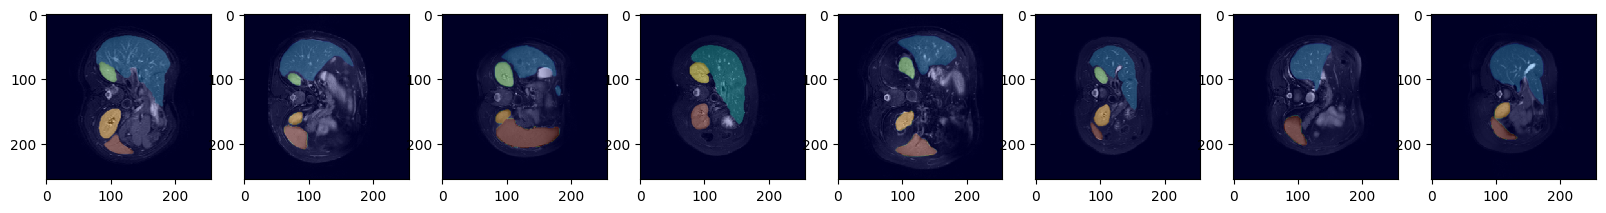

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

img_slices, mask_slices = [], []
for train_id in train_ids:
    image, mask = read_train_exam(train_id)
    a = np.unique(np.where(mask.get_fdata()>0.)[2])
    z = a[int(1*len(a)/2)]
    img_slices.append(resize(image.get_fdata()[:,:,z],(256,256),mode='reflect',anti_aliasing=True))
    mask_slices.append(resize(mask.get_fdata()[:,:,z],(256,256),mode='reflect',anti_aliasing=True))

plt.figure(figsize=(20, 15))
for i in range(len(train_ids)):
    plt.subplot(1, len(train_ids), i+1)
    plt.imshow(img_slices[i], cmap='gray', interpolation='nearest')
    plt.imshow(mask_slices[i], cmap='jet', alpha=0.3)
plt.show()

Pendant vos expérimentations, des examens d'apprentissage peuvent être utilisés comme "données de test" pour valider les modèles obtenus.

In [6]:
test_id_1, test_id_2 = 13, 19
slice_1, slice_2 = 13, 13
image_1, mask_1 = read_train_exam(test_id_1)
image_2, mask_2 = read_train_exam(test_id_2)
slice_im_1 = image_1.get_fdata()[:,:,slice_1]
slice_im_2 = image_2.get_fdata()[:,:,slice_2]
slice_mask_1 = mask_1.get_fdata()[:,:,slice_1].astype(np.uint8)
slice_mask_2 = mask_2.get_fdata()[:,:,slice_2].astype(np.uint8)


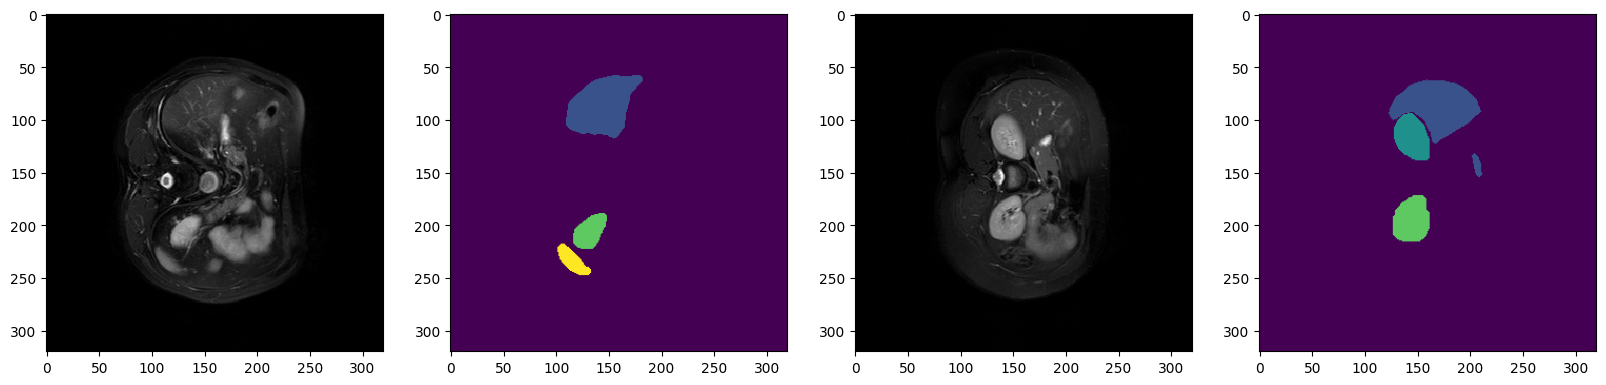

In [7]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 4, 1)
plt.imshow(slice_im_1, cmap='gray', interpolation='nearest')
plt.subplot(1, 4, 2)
plt.imshow(slice_mask_1,vmin=0,vmax=4)
plt.subplot(1, 4, 3)
plt.imshow(slice_im_2, cmap='gray', interpolation='nearest')
plt.subplot(1, 4, 4)
plt.imshow(slice_mask_2,vmin=0,vmax=4)
plt.show()

### 2 - Baseline

Prenons une approche basée apprentissage statistique.

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from skimage.restoration import denoise_tv_bregman

def extract_supervoxel_features(image_data, slic_labels):
    print("Extraction des features des supervoxels")
    # Débruitage TV-Bregman
    denoised = denoise_tv_bregman(image_data, weight=1.0)
    supervoxel_ids = np.unique(slic_labels)
    features_list = []
    for sv_id in supervoxel_ids:
        # Masque du supervoxel
        mask = (slic_labels == sv_id)
        voxels_in_sv = image_data[mask]
        voxels_denoised = denoised[mask]
        # Coordonnées spatiales du supervoxel
        coords = np.array(np.where(mask)).T  # (n_voxels, 3)
        # Features statistiques de l'intensité
        feat_mean_intensity = np.mean(voxels_in_sv)
        feat_std_intensity = np.std(voxels_in_sv)
        feat_min_intensity = np.min(voxels_in_sv)
        feat_max_intensity = np.max(voxels_in_sv)
        feat_median_intensity = np.median(voxels_in_sv)
        # Features du signal débruité
        feat_mean_denoised = np.mean(voxels_denoised)
        feat_std_denoised = np.std(voxels_denoised)
        # Features spatiales (position moyenne du supervoxel)
        feat_x = np.mean(coords[:, 0]) / image_data.shape[0]
        feat_y = np.mean(coords[:, 1]) / image_data.shape[1]
        feat_z = np.mean(coords[:, 2]) / image_data.shape[2]
        # Taille du supervoxel
        feat_size = len(voxels_in_sv)
        # Écart-type des positions
        feat_spatial_std_x = np.std(coords[:, 0]) / image_data.shape[0]
        feat_spatial_std_y = np.std(coords[:, 1]) / image_data.shape[1]
        feat_spatial_std_z = np.std(coords[:, 2]) / image_data.shape[2]

        features = [
            feat_mean_intensity,
            feat_std_intensity,
            feat_min_intensity,
            feat_max_intensity,
            feat_median_intensity,
            feat_mean_denoised,
            feat_std_denoised,
            feat_x,
            feat_y,
            feat_z,
            feat_size,
            feat_spatial_std_x,
            feat_spatial_std_y,
            feat_spatial_std_z]

        features_list.append(features)

    features = np.array(features_list)
    print(f"Features extraites: {features.shape}")

    return features, supervoxel_ids

#assign organ au supervoxel
def extract_supervoxel_labels(slic_labels, mask_data):
    print("Extraction des labels des supervoxels avec le mask")

    supervoxel_ids = np.unique(slic_labels)
    labels_list = []

    for sv_id in supervoxel_ids:
        mask = (slic_labels == sv_id)
        organ_labels = mask_data[mask].astype(int)
        # Label majoritaire dans le supervoxel
        if len(organ_labels) > 0:
            label = np.bincount(organ_labels).argmax()
        else:
            label = 0
        labels_list.append(label)

    labels = np.array(labels_list)
    print(f"Labels extraits: {labels.shape}")

    return labels


def train_rf_on_supervoxels(train_ids, read_train_exam):
    print("ENTRAÎNEMENT DU RANDOM FOREST")

    all_features = []
    all_labels = []

    for train_id in train_ids:
        print(f"\nTraitement de l'examen {train_id}...")
        image, mask = read_train_exam(train_id)

        # Calcul SLIC
        slic_labels = slic_only(image.get_fdata())

        # Extraction features et labels
        features, _ = extract_supervoxel_features(image.get_fdata(), slic_labels)
        labels = extract_supervoxel_labels(slic_labels, mask.get_fdata())

        all_features.append(features)
        all_labels.append(labels)

    # Concaténation de toutes les données
    X_train = np.vstack(all_features)
    y_train = np.concatenate(all_labels)

    print(f"\nDonnées d'entraînement: {X_train.shape}")
    print(f"Distribution des classes: {np.bincount(y_train.astype(int))}")

    # Normalisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Entraînement RandomForest
    print("\nEntraînement du RandomForest...")
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    clf.fit(X_train_scaled, y_train)

    print("Entraînement terminé!")

    return clf, scaler


def predict_on_supervoxels(image_data, slic_labels, clf, scaler):
    print("Prediction d'organes sur les supervoxels")
    # Extraction des features
    features, supervoxel_ids = extract_supervoxel_features(image_data, slic_labels)

    # Normalisation
    features_scaled = scaler.transform(features)

    # Prédiction
    predictions = clf.predict(features_scaled)

    # Reconstruction de la segmentation 3D
    segmentation = np.zeros_like(slic_labels)
    for sv_id, pred_label in zip(supervoxel_ids, predictions):
        mask = (slic_labels == sv_id)
        segmentation[mask] = pred_label

    print("Prédiction terminée!")

    return segmentation

In [9]:
import numpy as np
import nibabel as nib
from skimage.segmentation import slic
from skimage.restoration import denoise_tv_bregman

def slic_only(image_data):
    #debruitage
    image_debr = denoise_tv_bregman(image_data, weight=1.0)
    #SLIC
    slic_labels = slic(
        image_debr.astype(np.float32),
        n_segments = 10000 ,
        compactness = 0.1 ,
        channel_axis=None,  # Image 3D monovoxel
        start_label=0
    )

    print(f"SLIC terminé: {slic_labels.max() + 1} supervoxels.")
    return slic_labels

In [10]:
#DICE
def compute_dice(res, gt, label):
    A = gt == label
    B = res == label
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0:
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

def compute_dice_exam(seg, mask):
    dice_liver = compute_dice(seg, mask, 1)
    dice_rkidney = compute_dice(seg, mask, 2)
    dice_lkidney = compute_dice(seg, mask, 3)
    dice_spleen = compute_dice(seg, mask, 4)
    return dice_liver, dice_rkidney, dice_lkidney, dice_spleen


SLIC terminé: 8342 supervoxels.


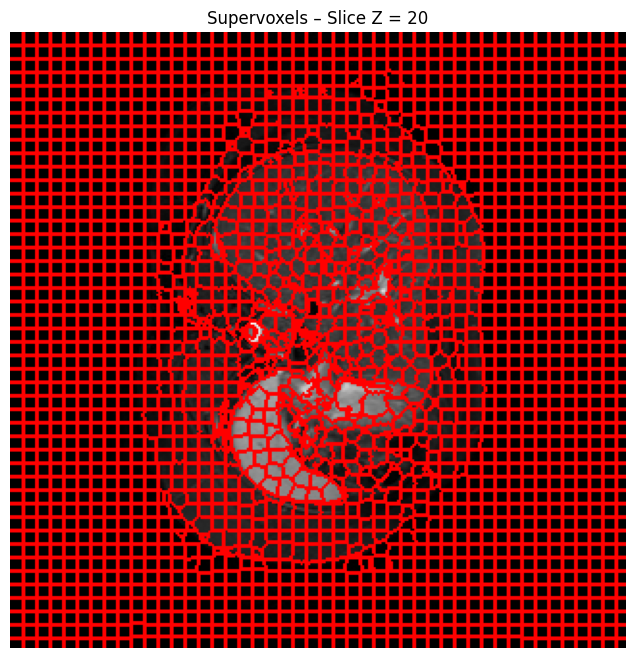

Extraction des labels des supervoxels avec le mask
Labels extraits: (8342,)
(90.91766199034517, 88.63113590760045, 82.94057625965696, 83.2914201183432)


In [11]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def plot_existing_slic(img_3d, slic_labels, slice_index=None):

    assert img_3d.shape == slic_labels.shape, \
        f"Image shape {img_3d.shape} ≠ labels shape {slic_labels.shape}"

    z = slice_index if slice_index is not None else img_3d.shape[2] // 2
    img_slice = img_3d[:, :, z].astype(np.float32)
    labels_slice = slic_labels[:, :, z]

     # Normalisation pour affichage

    img_slice -= img_slice.min()
    if img_slice.max() > 0:
        img_slice /= img_slice.max()

    # Ajout des contours de supervoxels
    img_with_boundaries = mark_boundaries(img_slice, labels_slice, color=(1, 0, 0))

    plt.figure(figsize=(8, 8))
    plt.imshow(img_with_boundaries, cmap='gray')
    plt.title(f"Supervoxels – Slice Z = {z}")
    plt.axis('off')
    plt.show()

labels = slic_only(image_2.get_fdata())
plot_existing_slic(image_2.get_fdata(), labels, slice_index=20)
#"triche" en utilizant le mask
seg_labels= extract_supervoxel_labels(labels, mask_2.get_fdata())
segmented_image = seg_labels[labels]
print(compute_dice_exam(segmented_image, mask_2.get_fdata()))


In [12]:
# Entraînement sur tous les examens d'entraînement
clf, scaler = train_rf_on_supervoxels(
    train_ids,  # ou train_ids pour tous
    read_train_exam,)

ENTRAÎNEMENT DU RANDOM FOREST

Traitement de l'examen 1...
SLIC terminé: 10904 supervoxels.
Extraction des features des supervoxels
Features extraites: (10904, 14)
Extraction des labels des supervoxels avec le mask
Labels extraits: (10904,)

Traitement de l'examen 2...
SLIC terminé: 10969 supervoxels.
Extraction des features des supervoxels
Features extraites: (10969, 14)
Extraction des labels des supervoxels avec le mask
Labels extraits: (10969,)

Traitement de l'examen 3...
SLIC terminé: 8346 supervoxels.
Extraction des features des supervoxels
Features extraites: (8346, 14)
Extraction des labels des supervoxels avec le mask
Labels extraits: (8346,)

Traitement de l'examen 5...
SLIC terminé: 9077 supervoxels.
Extraction des features des supervoxels
Features extraites: (9077, 14)
Extraction des labels des supervoxels avec le mask
Labels extraits: (9077,)

Traitement de l'examen 8...
SLIC terminé: 11289 supervoxels.
Extraction des features des supervoxels
Features extraites: (11289, 14

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.5s


Entraînement terminé!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished


In [13]:
def visualize_results(test_id_1, test_id_2, slice_1, slice_2,
                     read_train_exam, clf, scaler):
    import matplotlib.pyplot as plt
    # Examen 1
    print(f"\n=== Traitement examen {test_id_1} ===")
    image_1, mask_1 = read_train_exam(test_id_1)
    slic_1 = slic_only(image_1.get_fdata())
    seg_1 = predict_on_supervoxels(image_1.get_fdata(), slic_1, clf, scaler)

    # Examen 2
    print(f"\n=== Traitement examen {test_id_2} ===")
    image_2, mask_2 = read_train_exam(test_id_2)
    slic_2 = slic_only(image_2.get_fdata())
    seg_2 = predict_on_supervoxels(image_2.get_fdata(), slic_2, clf, scaler)

    # Calcul des Dice scores
    dice_1 = compute_dice_exam(seg_1, mask_1.get_fdata())
    dice_2 = compute_dice_exam(seg_2, mask_2.get_fdata())

    print(f"\n=== RÉSULTATS ===")
    print(f"Examen {test_id_1} - Dice scores: Foie={dice_1[0]:.2f}%, Rein D={dice_1[1]:.2f}%, Rein G={dice_1[2]:.2f}%, Rate={dice_1[3]:.2f}%")
    print(f"Examen {test_id_2} - Dice scores: Foie={dice_2[0]:.2f}%, Rein D={dice_2[1]:.2f}%, Rein G={dice_2[2]:.2f}%, Rate={dice_2[3]:.2f}%")

    # Extraction des slices
    slice_im_1 = image_1.get_fdata()[:, :, slice_1]
    slice_mask_1 = mask_1.get_fdata()[:, :, slice_1].astype(np.uint8)
    slice_seg_1 = seg_1[:, :, slice_1].astype(np.uint8)

    slice_im_2 = image_2.get_fdata()[:, :, slice_2]
    slice_mask_2 = mask_2.get_fdata()[:, :, slice_2].astype(np.uint8)
    slice_seg_2 = seg_2[:, :, slice_2].astype(np.uint8)

    # Visualisation
    plt.figure(figsize=(20, 10))

    # Examen 1 - Image + Ground Truth
    plt.subplot(2, 3, 1)
    plt.imshow(slice_im_1, cmap='gray', interpolation='nearest')
    plt.imshow(slice_mask_1, cmap='jet', alpha=0.5, vmin=0, vmax=4)
    plt.title(f'Examen {test_id_1} - Ground Truth (Slice {slice_1})', fontsize=14)
    plt.axis('off')

    # Examen 1 - Image + Prédiction
    plt.subplot(2, 3, 2)
    plt.imshow(slice_im_1, cmap='gray', interpolation='nearest')
    plt.imshow(slice_seg_1, cmap='jet', alpha=0.5, vmin=0, vmax=4)
    plt.title(f'Examen {test_id_1} - Prédiction RF (Slice {slice_1})', fontsize=14)
    plt.axis('off')

    # Examen 1 - Comparaison GT vs Pred
    plt.subplot(2, 3, 3)
    plt.imshow(slice_mask_1, cmap='jet', vmin=0, vmax=4)
    plt.title(f'GT - Dice: L={dice_1[0]:.1f}% RD={dice_1[1]:.1f}%\nRG={dice_1[2]:.1f}% R={dice_1[3]:.1f}%', fontsize=12)
    plt.axis('off')

    # Examen 2 - Image + Ground Truth
    plt.subplot(2, 3, 4)
    plt.imshow(slice_im_2, cmap='gray', interpolation='nearest')
    plt.imshow(slice_mask_2, cmap='jet', alpha=0.5, vmin=0, vmax=4)
    plt.title(f'Examen {test_id_2} - Ground Truth (Slice {slice_2})', fontsize=14)
    plt.axis('off')

    # Examen 2 - Image + Prédiction
    plt.subplot(2, 3, 5)
    plt.imshow(slice_im_2, cmap='gray', interpolation='nearest')
    plt.imshow(slice_seg_2, cmap='jet', alpha=0.5, vmin=0, vmax=4)
    plt.title(f'Examen {test_id_2} - Prédiction RF (Slice {slice_2})', fontsize=14)
    plt.axis('off')

    # Examen 2 - Comparaison GT vs Pred
    plt.subplot(2, 3, 6)
    plt.imshow(slice_mask_2, cmap='jet', vmin=0, vmax=4)
    plt.title(f'GT - Dice: L={dice_2[0]:.1f}% RD={dice_2[1]:.1f}%\nRG={dice_2[2]:.1f}% R={dice_2[3]:.1f}%', fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return seg_1, seg_2, dice_1, dice_2



=== Traitement examen 21 ===
SLIC terminé: 9104 supervoxels.
Prediction d'organes sur les supervoxels
Extraction des features des supervoxels
Features extraites: (9104, 14)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Prédiction terminée!

=== Traitement examen 22 ===
SLIC terminé: 9089 supervoxels.
Prediction d'organes sur les supervoxels
Extraction des features des supervoxels
Features extraites: (9089, 14)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Prédiction terminée!

=== RÉSULTATS ===
Examen 21 - Dice scores: Foie=79.14%, Rein D=87.82%, Rein G=86.59%, Rate=88.09%
Examen 22 - Dice scores: Foie=85.25%, Rein D=79.55%, Rein G=78.03%, Rate=91.88%


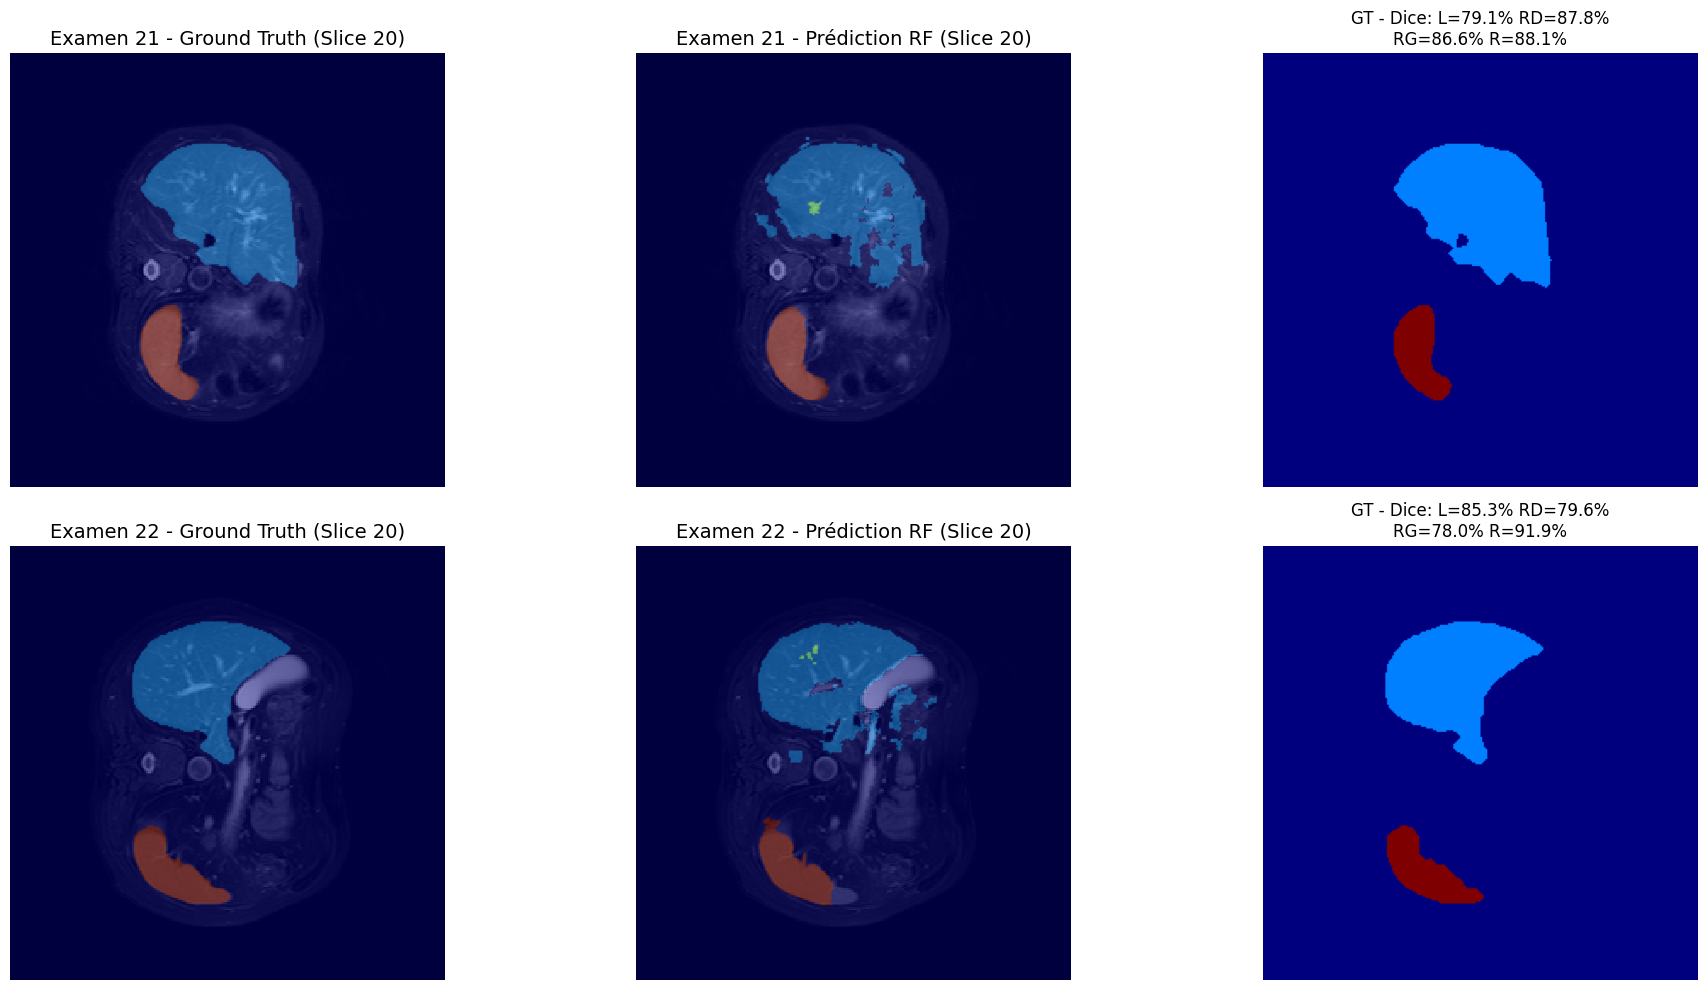

In [14]:
# 2. Visualisation des test 21 et 22
seg_1, seg_2, dice_1, dice_2 = visualize_results(
    test_id_1=21,
    test_id_2=22,
    slice_1=20,
    slice_2=20,
    read_train_exam=read_train_exam,
    clf=clf,
    scaler=scaler
)



=== Traitement examen 32 ===
SLIC terminé: 10924 supervoxels.
Prediction d'organes sur les supervoxels
Extraction des features des supervoxels
Features extraites: (10924, 14)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Prédiction terminée!

=== Traitement examen 39 ===
SLIC terminé: 7307 supervoxels.
Prediction d'organes sur les supervoxels
Extraction des features des supervoxels
Features extraites: (7307, 14)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Prédiction terminée!

=== RÉSULTATS ===
Examen 32 - Dice scores: Foie=83.39%, Rein D=63.91%, Rein G=57.25%, Rate=73.50%
Examen 39 - Dice scores: Foie=48.50%, Rein D=42.71%, Rein G=51.87%, Rate=0.00%


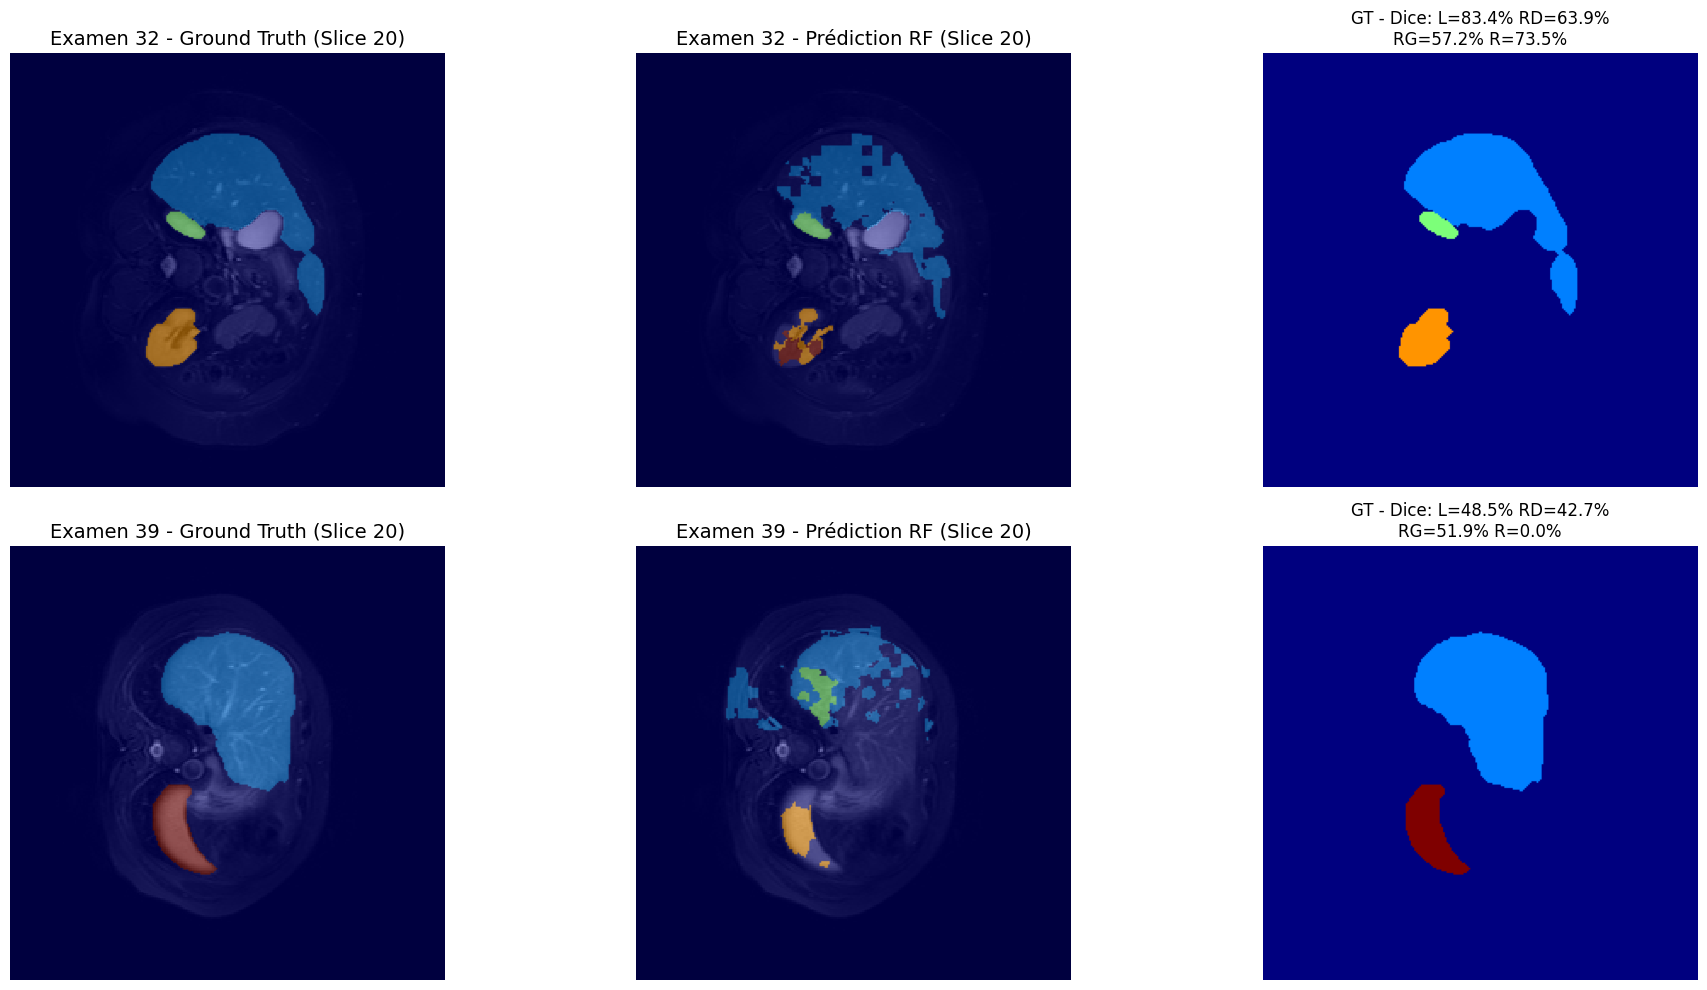

In [15]:
# 2. Visualisation des test 32 et 39
seg_3, seg_4, dice_3, dice_4 = visualize_results(
    test_id_1=32,
    test_id_2=39,
    slice_1=20,
    slice_2=20,
    read_train_exam=read_train_exam,
    clf=clf,
    scaler=scaler
)



=== Traitement examen 13 ===
SLIC terminé: 8302 supervoxels.
Prediction d'organes sur les supervoxels
Extraction des features des supervoxels
Features extraites: (8302, 14)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Prédiction terminée!

=== Traitement examen 19 ===
SLIC terminé: 8342 supervoxels.
Prediction d'organes sur les supervoxels
Extraction des features des supervoxels
Features extraites: (8342, 14)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Prédiction terminée!

=== RÉSULTATS ===
Examen 13 - Dice scores: Foie=88.11%, Rein D=90.21%, Rein G=87.42%, Rate=85.21%
Examen 19 - Dice scores: Foie=90.68%, Rein D=88.63%, Rein G=80.52%, Rate=83.29%


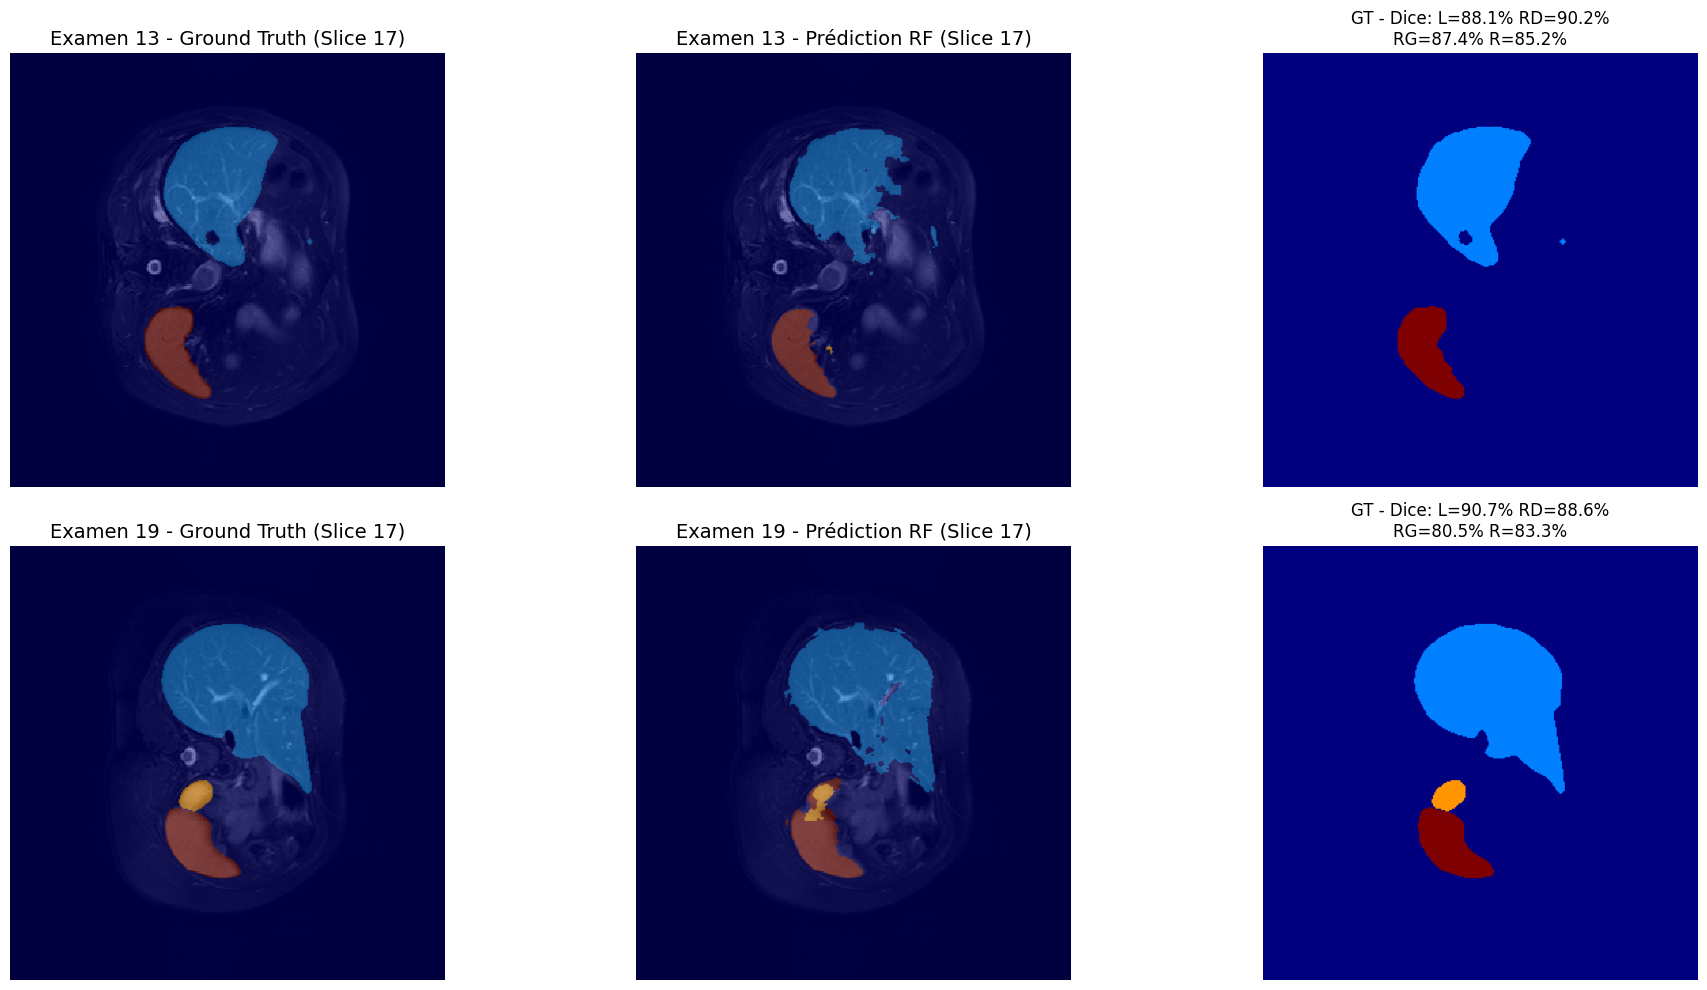

In [16]:
# 2. prediction des train 13 et 19

seg_1, seg_2, dice_1, dice_2 = visualize_results(
    test_id_1=13,
    test_id_2=19,
    slice_1=17,
    slice_2=17,
    read_train_exam=read_train_exam,
    clf=clf,
    scaler=scaler
)

In [17]:
def visualize_test_results(test_id_1, test_id_2, slice_1, slice_2,
                          read_test_exam, clf, scaler):
#Visualise les résultats de segmentation pour deux examens TEST (sans ground truth)
    import matplotlib.pyplot as plt

    # test 1
    print(f"\n=== Traitement examen test {test_id_1} ===")
    image_1 = read_test_exam(test_id_1)
    slic_1 = slic_only(image_1.get_fdata())
    seg_1 = predict_on_supervoxels(image_1.get_fdata(), slic_1, clf, scaler)

    # test 2
    print(f"\n=== Traitement examen test {test_id_2} ===")
    image_2 = read_test_exam(test_id_2)
    slic_2 = slic_only(image_2.get_fdata())
    seg_2 = predict_on_supervoxels(image_2.get_fdata(), slic_2, clf, scaler)

    # slices
    slice_im_1 = image_1.get_fdata()[:, :, slice_1]
    slice_seg_1 = seg_1[:, :, slice_1].astype(np.uint8)

    slice_im_2 = image_2.get_fdata()[:, :, slice_2]
    slice_seg_2 = seg_2[:, :, slice_2].astype(np.uint8)

    # Visualisation
    plt.figure(figsize=(16, 8))

    # test 1 - Image seule
    plt.subplot(2, 3, 1)
    plt.imshow(slice_im_1, cmap='gray', interpolation='nearest')
    plt.title(f'Examen Test {test_id_1} - Image originale (Slice {slice_1})', fontsize=14)
    plt.axis('off')

    # test 1 - Image + Prédiction
    plt.subplot(2, 3, 2)
    plt.imshow(slice_im_1, cmap='gray', interpolation='nearest')
    plt.imshow(slice_seg_1, cmap='jet', alpha=0.5, vmin=0, vmax=4)
    plt.title(f'Examen Test {test_id_1} - Prédiction RF (Slice {slice_1})', fontsize=14)
    plt.axis('off')

    # test 1 - Prédiction seule
    plt.subplot(2, 3, 3)
    plt.imshow(slice_seg_1, cmap='jet', vmin=0, vmax=4)
    plt.title(f'Examen Test {test_id_1} - Masque prédit', fontsize=14)
    plt.colorbar(label='Classe (0=BG, 1=Foie, 2=Rein D, 3=Rein G, 4=Rate)', shrink=0.8)
    plt.axis('off')

    # test 2 - Image seule
    plt.subplot(2, 3, 4)
    plt.imshow(slice_im_2, cmap='gray', interpolation='nearest')
    plt.title(f'Examen Test {test_id_2} - Image originale (Slice {slice_2})', fontsize=14)
    plt.axis('off')

    # test 2 - Image + Prédiction
    plt.subplot(2, 3, 5)
    plt.imshow(slice_im_2, cmap='gray', interpolation='nearest')
    plt.imshow(slice_seg_2, cmap='jet', alpha=0.5, vmin=0, vmax=4)
    plt.title(f'Examen Test {test_id_2} - Prédiction RF (Slice {slice_2})', fontsize=14)
    plt.axis('off')

    # test 2 - Prédiction seule
    plt.subplot(2, 3, 6)
    plt.imshow(slice_seg_2, cmap='jet', vmin=0, vmax=4)
    plt.title(f'Examen Test {test_id_2} - Masque prédit', fontsize=14)
    plt.colorbar(label='Classe (0=BG, 1=Foie, 2=Rein D, 3=Rein G, 4=Rate)', shrink=0.8)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return seg_1, seg_2


=== Traitement examen test 21 ===
SLIC terminé: 9104 supervoxels.
Prediction d'organes sur les supervoxels
Extraction des features des supervoxels
Features extraites: (9104, 14)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Prédiction terminée!

=== Traitement examen test 22 ===
SLIC terminé: 9089 supervoxels.
Prediction d'organes sur les supervoxels
Extraction des features des supervoxels
Features extraites: (9089, 14)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Prédiction terminée!


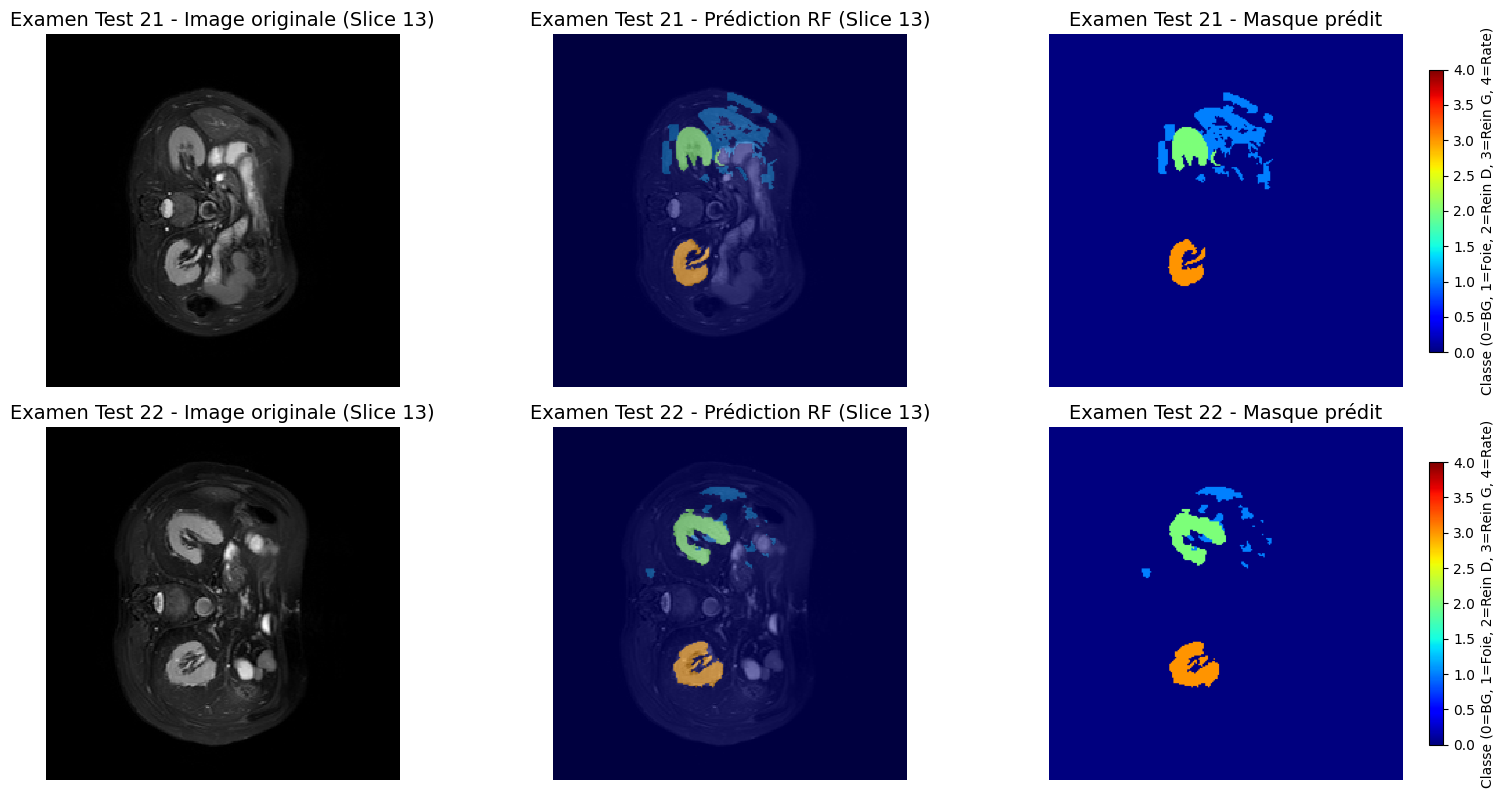

In [20]:
# Visualisation des examens test 21 et 22
seg_test_21, seg_test_22 = visualize_test_results(
    test_id_1=21,
    test_id_2=22,
    slice_1=13,
    slice_2=13,
    read_test_exam=read_test_exam,  # Assurez-vous d'avoir cette fonction
    clf=clf,
    scaler=scaler
)

In [21]:
#Algo pour comparer les SLICs
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic
from skimage.restoration import denoise_tv_bregman

def visualize_slic_comparison(image_data, n_segments_values, compactness_values, slice_index):
    num_n_segments = len(n_segments_values)
    num_compactness = len(compactness_values)
    nrows = num_n_segments
    ncols = num_compactness

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
    fig.suptitle(f'SLIC Segmentation Comparison for Slice Z={slice_index}', fontsize=16)

    for i, n_segments in enumerate(n_segments_values):
        for j, compactness in enumerate(compactness_values):
            print(f"Processing n_segments={n_segments}, compactness={compactness}")
            # Apply SLIC
            slic_labels = slic_only_eval(image_data, n_segments, compactness)

            # Extract the specific slice from image_data and slic_labels
            img_slice = image_data[:, :, slice_index].astype(np.float32)
            labels_slice = slic_labels[:, :, slice_index]

            # Normalize image slice for better visualization
            img_slice_normalized = img_slice - img_slice.min()
            if img_slice_normalized.max() > 0:
                img_slice_normalized /= img_slice_normalized.max()

            # Draw superpixel
            img_with_boundaries = mark_boundaries(img_slice_normalized, labels_slice, color=(1, 0, 0))

            # Get the current subplot axis
            ax = axes[i, j] if nrows > 1 and ncols > 1 else (axes[i] if ncols == 1 else axes[j])

            ax.imshow(img_with_boundaries, cmap='gray')
            ax.set_title(f'n_seg: {n_segments}, comp: {compactness}', fontsize=10)
            ax.axis('off') # Turn off axis for cleaner look

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()

#slic avec parametre variable:
def slic_only_eval(image_data, n_segments, compactness):
    #debruitage
    image_debr = denoise_tv_bregman(image_data, weight=1.0)
    #SLIC
    slic_labels = slic(
        image_debr.astype(np.float32),
        n_segments = n_segments,
        compactness = compactness ,
        channel_axis=None,  # Image 3D monovoxel
        start_label=0
    )

    print(f"SLIC terminé: {slic_labels.max() + 1} supervoxels.")
    return slic_labels

Processing n_segments=1000, compactness=0.01
SLIC terminé: 907 supervoxels.
Processing n_segments=1000, compactness=0.1
SLIC terminé: 1174 supervoxels.
Processing n_segments=1000, compactness=1.0
SLIC terminé: 1200 supervoxels.
Processing n_segments=5000, compactness=0.01
SLIC terminé: 3927 supervoxels.
Processing n_segments=5000, compactness=0.1
SLIC terminé: 5015 supervoxels.
Processing n_segments=5000, compactness=1.0
SLIC terminé: 5120 supervoxels.
Processing n_segments=10000, compactness=0.01
SLIC terminé: 8716 supervoxels.
Processing n_segments=10000, compactness=0.1
SLIC terminé: 10904 supervoxels.
Processing n_segments=10000, compactness=1.0
SLIC terminé: 11087 supervoxels.


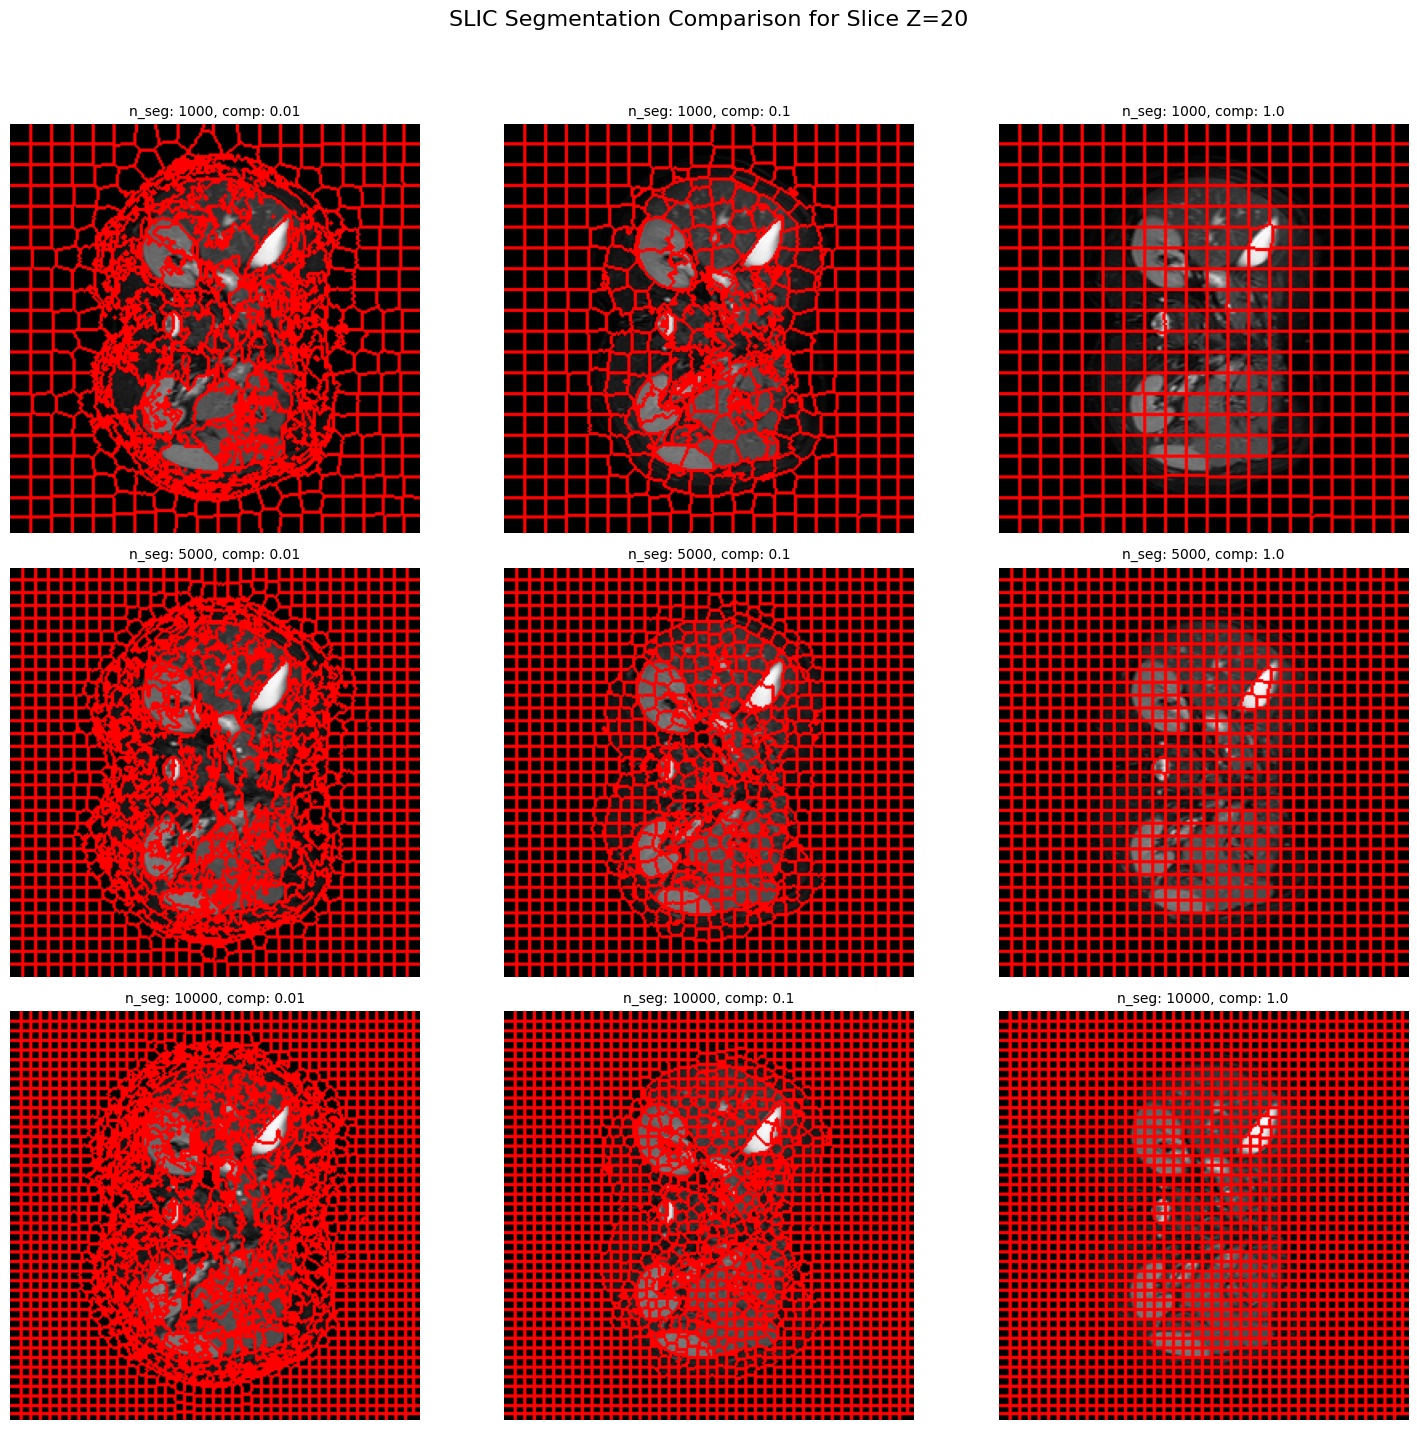

In [22]:
image_for_comparison, _ = read_train_exam(train_ids[0])
slice_to_compare = 20
n_segments_values = [1000, 5000, 10000]
compactness_values = [0.01, 0.1, 1.0]

visualize_slic_comparison(
    image_data=image_for_comparison.get_fdata(),
    n_segments_values=n_segments_values,
    compactness_values=compactness_values,
    slice_index=slice_to_compare
)